## Notebook to report descriptive statistics from demoraphic and assessment data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

### Paths


In [4]:
DATASET_ROOT = "/home/nikhil/projects/Parkinsons/qpn/"

# Current nipoppy release
current_release = "June_2024"

data_release_dir = f"{DATASET_ROOT}/releases/{current_release}/"
tabular_data_release_dir = f"{data_release_dir}/tabular/"
manifest_file = f"{data_release_dir}/manifest.csv"

# tabular files
demographics_file = f"{tabular_data_release_dir}/demographics.csv"
mri_session_date_file = f"{tabular_data_release_dir}/mri_sessions.csv"
updrs_file = f"{tabular_data_release_dir}/assessments/updrs.csv"
moca_file = f"{tabular_data_release_dir}/assessments/moca.csv"
dx_file = f"{tabular_data_release_dir}/assessments/diagnosis.csv"
neuropsych_file = f"{tabular_data_release_dir}/assessments/neuropsych.csv"

### Defs

In [5]:
def subset_and_replace_df(df, filters_dict, rename_dict):
    """ Subset rows and replace columns values in a dataframe
    """
    for col, val_list in filters_dict.items():
        df = df[df[col].isin(val_list)].copy()

    for col, val_list in rename_dict.items():
        df[col] = df[col].replace(val_list).copy()

    return df
    


def get_group_table_stats(df, cat_cols, score_cols, groupby_col="redcap_event_name"):
    """ Get table stats for groups. Does not stratify by group! 
    """
    n_cat_cols = len(cat_cols)
    n_score_cols = len(score_cols)
    print(f"Counting {n_cat_cols} and averaging {n_score_cols}")

    table_df = df["redcap_event_name"].value_counts().reset_index()
    print("Starting cat cols")
    for col in cat_cols:
        # print(f"col: {col}")
        cat_count_df = df.groupby([groupby_col])[col].value_counts().unstack().reset_index()
        table_df = pd.merge(table_df, cat_count_df, on=groupby_col, how="left")

    print("Starting score cols")
    for col in score_cols:
        # print(f"col: {col}")
        score_count = df.groupby([groupby_col])[col].count()
        score_mean_df = df.groupby([groupby_col])[col].mean().round(1)
        score_std_df = df.groupby([groupby_col])[col].std().round(1)
        score_min_df = df.groupby([groupby_col])[col].min().round(1)
        score_max_df = df.groupby([groupby_col])[col].max().round(1)
        score_mean_std_df = "non-null-count: " + score_count.astype(str) + " " + score_mean_df.astype(str) + " (" + score_std_df.astype(str) + ")" + " ["  \
        + score_min_df.astype(str) + ", " + score_max_df.astype(str) + "]"
        score_mean_std_df = score_mean_std_df.reset_index()
        # score_mean_std_df["non-null-count"] = score_count
        table_df = pd.merge(table_df, score_mean_std_df, on=groupby_col, how="left")
    
    return table_df

### Load data

In [6]:
manifest_df = pd.read_csv(manifest_file)
demo_df = pd.read_csv(demographics_file)
mri_df = pd.read_csv(mri_session_date_file)
updrs_df = pd.read_csv(updrs_file)
moca_df = pd.read_csv(moca_file)
dx_df = pd.read_csv(dx_file)
neuropsy_df = pd.read_csv(neuropsych_file)


### QPN paper tables

In [7]:
# paper subset filters
cohort_inclusion_list = ["QPN"]
group_inclusion_list = ["Healthy control/Contrôle", "PD   (Parkinson's Disease)/Maladie de Parkinson"]
visits_inclusion_list = ["Baseline (Arm 1: C-OPN)", "pre-redcap-baseline-1 (legacy)", "pre-redcap-baseline-2 (legacy)",
                         "12 Months Follow-Up/Suivi (Arm 1: C-OPN)","18 Months Follow-Up/Suivi (Arm 1: C-OPN)"]

participant_inclusion_criteria = {
    "redcap_event_name" : visits_inclusion_list, 
    "recruitment_cohort": cohort_inclusion_list,
    "group": group_inclusion_list
    }

QPN_groups = {"Healthy control/Contrôle": "control", "PD   (Parkinson's Disease)/Maladie de Parkinson": "PD", np.NaN:"Unknown"}
QPN_sexes = {"Female/Féminin": "Female", "Male/Masculin":"Male"}

col_val_replacement_criteria = {
    "group": QPN_groups,
    "sex": QPN_sexes
}

### Manifest

In [8]:
paper_df = pd.merge(manifest_df, demo_df, on="participant_id", how="left")
paper_df = paper_df[paper_df["recruitment_cohort"]=="QPN"]

n_tabular_participants = paper_df["participant_id"].nunique()
print(f"Number of participants: {n_tabular_participants}")

# Filter and replace values
paper_df = subset_and_replace_df(paper_df, participant_inclusion_criteria, col_val_replacement_criteria)
n_paper_participants = paper_df["participant_id"].nunique()
print(f"Number of participants after event and group filter: {n_paper_participants}")

session_counts = paper_df["session"].value_counts()
print(f"session_counts: {session_counts}")

paper_df.head()

Number of participants: 284
Number of participants after event and group filter: 275
session_counts: session
ses-01    275
ses-02     57
ses-03      5
Name: count, dtype: int64


,participant_id,visit,session,datatype,dicom_availabilty,redcap_event_name,recruitment_cohort,group,sex,education
0,MNI0215,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,control,Female,18.0
1,PD01145,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,PD,Male,12.0
2,MNI0313,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,control,Male,18.0
3,MNI0476,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,PD,Female,NaN
4,PD01214,MRI_v1,ses-01,"['anat','dwi','fmap','func']",yes,Baseline (Arm 1: C-OPN),QPN,PD,Female,17.0


#### Demo table
- Add MRI age column

In [9]:
# add mri_age column
paper_df = pd.merge(demo_df, mri_df[["participant_id", "redcap_event_name", "MRI_age"]], on=["participant_id", "redcap_event_name"], how="left")

n_tabular_participants = paper_df["participant_id"].nunique()
print(f"Number of participants: {n_tabular_participants}")

# Filter and replace values
paper_df = subset_and_replace_df(paper_df, participant_inclusion_criteria, col_val_replacement_criteria)
n_paper_participants = paper_df["participant_id"].nunique()
print(f"Number of participants after event and group filter: {n_paper_participants}")

redcap_events = paper_df["redcap_event_name"].unique()
print(f"redcap events: {redcap_events}")

paper_df.head()

Number of participants: 294
Number of participants after event and group filter: 275
redcap events: ['Baseline (Arm 1: C-OPN)']


,participant_id,redcap_event_name,recruitment_cohort,group,sex,education,MRI_age
0,MNI0028,Baseline (Arm 1: C-OPN),QPN,PD,Male,NaN,60.19
1,MNI0056,Baseline (Arm 1: C-OPN),QPN,PD,Male,12.0,79.24
2,MNI0058,Baseline (Arm 1: C-OPN),QPN,PD,Male,11.0,57.43
3,MNI0068,Baseline (Arm 1: C-OPN),QPN,PD,Male,11.0,69.30
4,MNI0079,Baseline (Arm 1: C-OPN),QPN,PD,Female,16.0,50.08


In [10]:
# counts
cat_cols = ["sex"]
score_cols = ["MRI_age"]

for dx_group in QPN_groups.values():
    print(f"*** group: {dx_group} ***")
    dx_group_df = paper_df[paper_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: control ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
         redcap_event_name  count  Female  Male  \
0  Baseline (Arm 1: C-OPN)     67      44    22   

                                       MRI_age  
0  non-null-count: 66 62.0 (11.6) [26.0, 82.8]  
----------
*** group: PD ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
         redcap_event_name  count  Female  Male  \
0  Baseline (Arm 1: C-OPN)    208      68   139   

                                       MRI_age  
0  non-null-count: 204 65.5 (8.9) [40.8, 88.3]  
----------
*** group: Unknown ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
Empty DataFrame
Columns: [count, redcap_event_name, MRI_age]
Index: []
----------


#### UPDRS table

In [11]:
paper_df = pd.merge(demo_df.drop(columns=["redcap_event_name"]), updrs_df, on=["participant_id"], how="right")
paper_df = pd.merge(paper_df, dx_df, on=["participant_id","redcap_event_name"], how="left")

n_tabular_participants = paper_df["participant_id"].nunique()
print(f"Number of participants: {n_tabular_participants}")

# Filter and replace values
paper_df = subset_and_replace_df(paper_df, participant_inclusion_criteria, col_val_replacement_criteria)
n_paper_mds_updrs_participants = paper_df[~paper_df["Part III: Motor Examination"].isna()]["redcap_event_name"].value_counts()
n_paper_legacy_updrs_participants = paper_df[~paper_df["legacy_updrs3_scores"].isna()]["participant_id"].nunique()
print(f"Number of mds-updrs participants after event and group filter: {n_paper_mds_updrs_participants}")
print(f"Number of legacy-updrs participants after event and group filter: {n_paper_legacy_updrs_participants}")

# find common participants between 12 and 18 month visits
participants_12m = paper_df[paper_df["redcap_event_name"] == "12 Months Follow-Up/Suivi (Arm 1: C-OPN)"]["participant_id"]
participants_18m = paper_df[paper_df["redcap_event_name"] == "18 Months Follow-Up/Suivi (Arm 1: C-OPN)"]["participant_id"]
participants_union = set(participants_12m) | set(participants_18m)
participants_intersection = set(participants_12m) & set(participants_18m)

print(f"participants_union: {len(participants_union)}")
print(f"participants_intersection: {len(participants_intersection)}")

paper_df.head()

Number of participants: 195
Number of mds-updrs participants after event and group filter: redcap_event_name
Baseline (Arm 1: C-OPN)                     163
12 Months Follow-Up/Suivi (Arm 1: C-OPN)     32
18 Months Follow-Up/Suivi (Arm 1: C-OPN)     13
Name: count, dtype: int64
Number of legacy-updrs participants after event and group filter: 11
participants_union: 42
participants_intersection: 5


,participant_id,recruitment_cohort,group,sex,education,redcap_event_name,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Part III: Motor Examination,Part IV: Motor Complications,updrs_age,legacy_updrs3_scores,legacy_updrs3_age,diagnosis,Hoehn and Yahr Stage:,diagnosis_age
0,MNI0028,QPN,PD,Male,NaN,Baseline (Arm 1: C-OPN),0.0,2.0,29.0,0.0,60.19,NaN,NaN,0.0,(2) Bilateral involvement without impairment o...,57.13
1,MNI0056,QPN,PD,Male,12.0,Baseline (Arm 1: C-OPN),12.0,22.0,58.0,0.0,79.06,NaN,NaN,0.0,(3) Bilateral disease: mild to moderate disabi...,75.28
2,MNI0058,QPN,PD,Male,11.0,Baseline (Arm 1: C-OPN),0.0,6.0,26.0,0.0,57.36,NaN,NaN,0.0,"(1) Unilateral involvement only, usually with ...",56.19
3,MNI0068,QPN,PD,Male,11.0,Baseline (Arm 1: C-OPN),11.0,8.0,28.0,0.0,69.30,NaN,NaN,0.0,(2) Bilateral involvement without impairment o...,61.65
4,MNI0079,QPN,PD,Female,16.0,Baseline (Arm 1: C-OPN),13.0,10.0,22.0,8.0,50.16,NaN,NaN,0.0,(2) Bilateral involvement without impairment o...,45.43


### Plot phono data

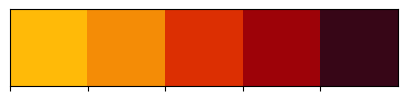

In [10]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

monocrome_hot = ["#370617","#6a040f","#9d0208","#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
monochrome_hot_palette = sns.color_palette(palette=monocrome_hot[::-2]) #sns.husl_palette()

sns.palplot(monochrome_hot_palette)


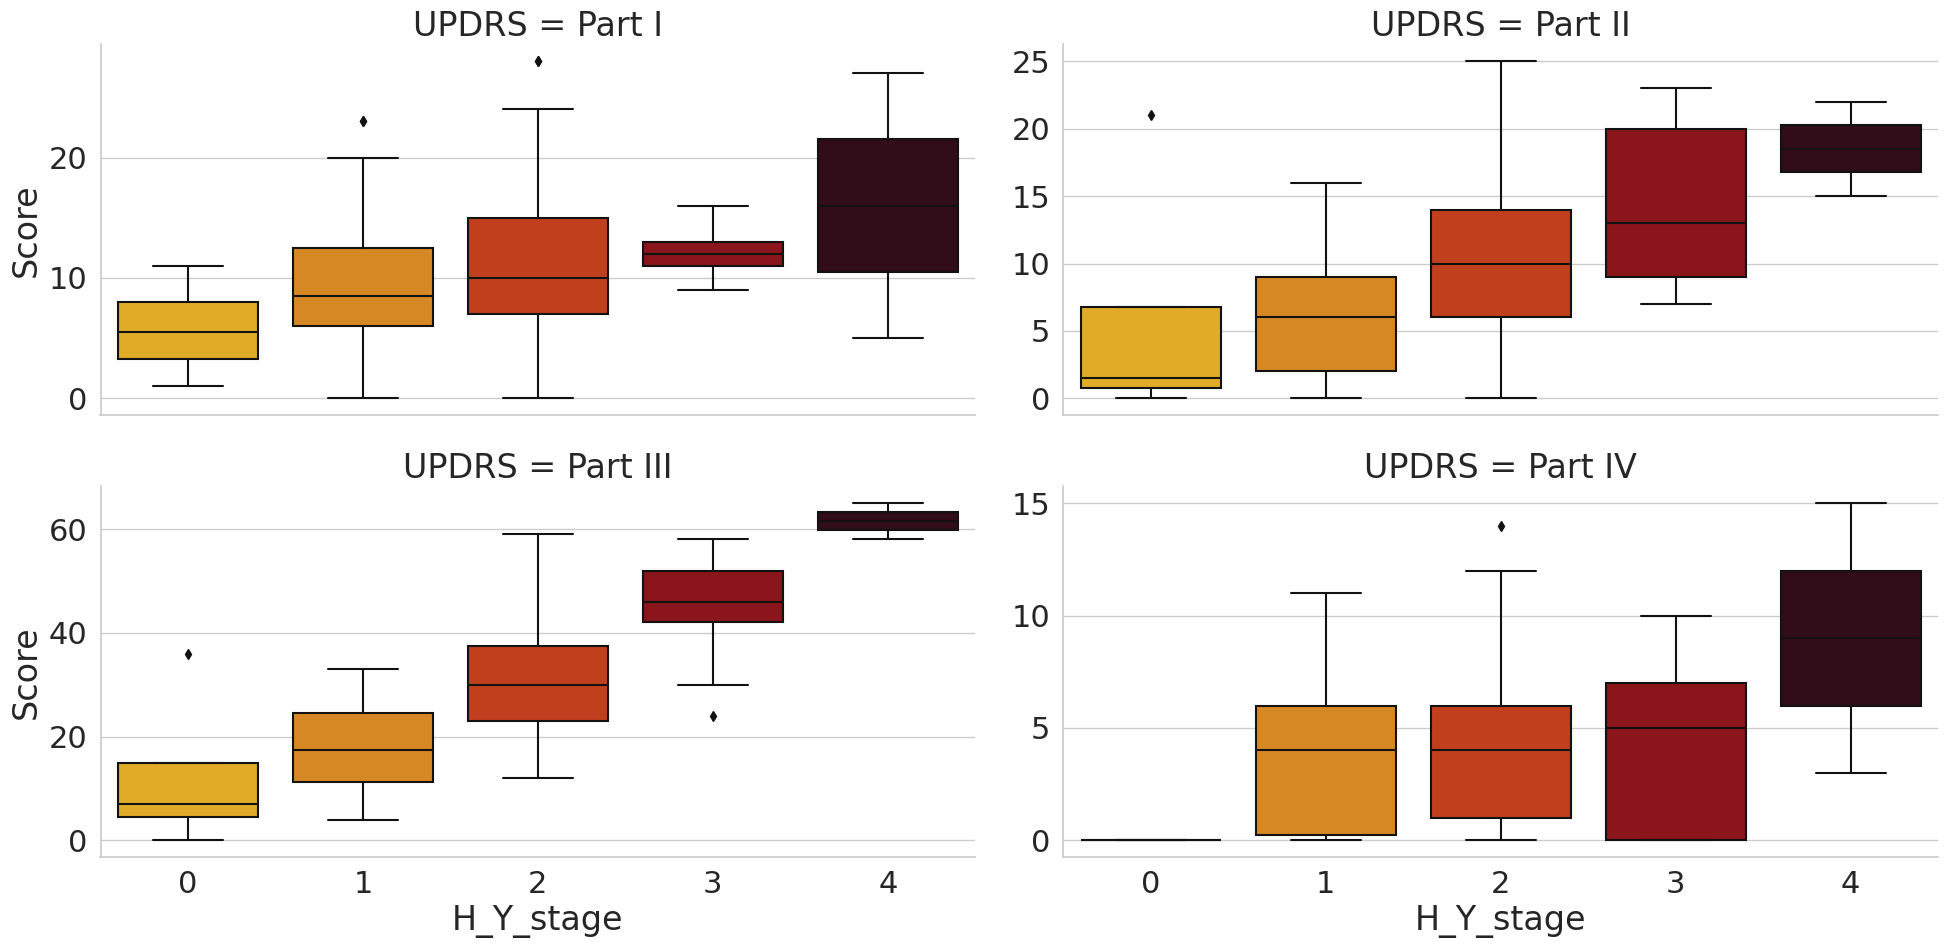

In [11]:
updrs_cols_dict = {
    "Hoehn and Yahr Stage: ":'H_Y_stage',
    'Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL)':'Part I',
    'Part II: Motor Aspects of Experiences of Daily Living (M-EDL)':'Part II',
    'Part III: Motor Examination':'Part III',
    'Part IV: Motor Complications':'Part IV',
}

H_Y_stage_dict = dict(zip(
    [
    '(2) Bilateral involvement without impairment of balance',
    '(3) Bilateral disease: mild to moderate disability with impaired postural reflexes; physically independent; needs assistance to recover from pull test',
    '(1) Unilateral involvement only, usually with minimal or no functional disability',
    '(0) Asymptomatic',
    '(4) Severely disabling disease; still able to walk or stand unassisted',
    np.nan], 
    
    ['2', '3', '1', '0', '4', "N/A"]
))

paper_df = paper_df.rename(columns=updrs_cols_dict)
paper_df["H_Y_stage"] = paper_df["H_Y_stage"].replace(H_Y_stage_dict)
paper_df = paper_df[paper_df["H_Y_stage"]!="N/A"]

# Melt for plotting
plot_df = pd.melt(paper_df, id_vars=["participant_id","redcap_event_name","group","H_Y_stage"], 
                  value_vars=['Part I', 'Part II', 'Part III', 'Part IV'], 
                  var_name="UPDRS", value_name="Score")

plot_df = plot_df[plot_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"]

stage_order = ['0', '1', '2', '3', '4']

sns.set_theme(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="Score",x="H_Y_stage", order=stage_order,
                    col="UPDRS", col_wrap=2, 
                    kind="box", palette=monochrome_hot_palette, 
                    data=plot_df, aspect=2, height=5, sharey=False)
    # g.set_xlabels("")
    # g.set_xticklabels("")

In [12]:
plot_df["group"].value_counts()

group
PD    608
Name: count, dtype: int64

In [13]:
cat_cols = ["H_Y_stage"]
score_cols = ["Part I", "Part II", "Part III", "Part IV"]

# paper_df = paper_df[paper_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"]

for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_group_df = paper_df[paper_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: PD ***
Counting 1 and averaging 4
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count    0     1      2    3  \
0                   Baseline (Arm 1: C-OPN)    152  4.0  34.0  103.0  9.0   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)     32  NaN   1.0   25.0  6.0   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)     14  NaN   NaN   10.0  4.0   

     4                                      Part I  \
0  2.0  non-null-count: 152 10.7 (6.0) [0.0, 28.0]   
1  NaN   non-null-count: 31 10.7 (6.4) [1.0, 25.0]   
2  NaN   non-null-count: 14 12.2 (5.3) [4.0, 23.0]   

                                     Part II  \
0  non-null-count: 151 9.6 (6.0) [0.0, 25.0]   
1  non-null-count: 31 10.2 (5.6) [1.0, 20.0]   
2  non-null-count: 13 12.1 (7.3) [1.0, 22.0]   

                                      Part III  \
0  non-null-count: 152 28.3 (13.3) [0.0, 65.0]   
1   non-null-count: 31 33.7 (12.4) [9.0, 65.0]   
2  non-null-count: 13 36.0 (12.5) [15

### Legacy score stats

In [81]:
updrs_df["legacy_updrs3_scores"].describe()

count    11.000000
mean     32.181818
std       7.386720
min      24.000000
25%      27.000000
50%      29.000000
75%      37.000000
max      45.000000
Name: legacy_updrs3_scores, dtype: float64

In [14]:
cat_cols = ["H_Y_stage"]
score_cols = ["legacy_updrs3_scores"]

# paper_df = paper_df[paper_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"]

for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_group_df = paper_df[paper_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: PD ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count    0     1      2    3  \
0                   Baseline (Arm 1: C-OPN)    152  4.0  34.0  103.0  9.0   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)     32  NaN   1.0   25.0  6.0   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)     14  NaN   NaN   10.0  4.0   

     4                    legacy_updrs3_scores  
0  2.0  non-null-count: 0 nan (nan) [nan, nan]  
1  NaN  non-null-count: 0 nan (nan) [nan, nan]  
2  NaN  non-null-count: 0 nan (nan) [nan, nan]  
----------
*** group: control ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
Empty DataFrame
Columns: [count, redcap_event_name, legacy_updrs3_scores]
Index: []
----------


### MoCA score

In [15]:
paper_df = pd.merge(demo_df.drop(columns=["redcap_event_name"]), moca_df, on=["participant_id"], how="right")
paper_df = pd.merge(paper_df, dx_df, on=["participant_id","redcap_event_name"], how="left")

n_tabular_participants = paper_df["participant_id"].nunique()
print(f"Number of participants: {n_tabular_participants}")

# Filter and replace values
paper_df = subset_and_replace_df(paper_df, participant_inclusion_criteria, col_val_replacement_criteria)
n_paper_participants = paper_df["participant_id"].nunique()
print(f"Number of participants after event and group filter: {n_paper_participants}")

redcap_event_counts = paper_df["redcap_event_name"].value_counts()
print(f"redcap_event_counts: {redcap_event_counts}")

# find common participants between redcap baseline and legacy baseline
participants_redcap_baseline = paper_df[paper_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]["participant_id"]
participants_legacy_baseline = paper_df[paper_df["redcap_event_name"] == "pre-redcap-baseline-1 (legacy)"]["participant_id"]
participants_union = set(participants_redcap_baseline) | set(participants_legacy_baseline)
participants_intersection = set(participants_redcap_baseline) & set(participants_legacy_baseline)

print("-"*50)
print("Common participants between redcap baseline and legacy baseline")
print(f"participants_union: {len(participants_union)}")
print(f"participants_intersection: {len(participants_intersection)}")
print("-"*50)

# find common participants between 12 and 18 month visits
participants_12m = paper_df[paper_df["redcap_event_name"] == "12 Months Follow-Up/Suivi (Arm 1: C-OPN)"]["participant_id"]
participants_18m = paper_df[paper_df["redcap_event_name"] == "18 Months Follow-Up/Suivi (Arm 1: C-OPN)"]["participant_id"]
participants_union = set(participants_12m) | set(participants_18m)
participants_intersection = set(participants_12m) & set(participants_18m)

print("Common participants between 12 and 18 month visits")
print(f"participants_union: {len(participants_union)}")
print(f"participants_intersection: {len(participants_intersection)}")
print("-"*50)

# find participants with at least 1 follow-up visit including legacy baseline
participants_legacy_followup = set(participants_redcap_baseline) & set(participants_legacy_baseline)
participants_followup = participants_legacy_followup | set(participants_12m) | set(participants_18m)
print("Participants with at least 1 follow-up visit including legacy baseline")
print(f"participants_followup: {len(participants_followup)}")
print("-"*50)

Number of participants: 252
Number of participants after event and group filter: 242
redcap_event_counts: redcap_event_name
Baseline (Arm 1: C-OPN)                     238
12 Months Follow-Up/Suivi (Arm 1: C-OPN)     43
pre-redcap-baseline-1 (legacy)               31
18 Months Follow-Up/Suivi (Arm 1: C-OPN)     12
pre-redcap-baseline-2 (legacy)                1
Name: count, dtype: int64
--------------------------------------------------
Common participants between redcap baseline and legacy baseline
participants_union: 240
participants_intersection: 29
--------------------------------------------------
Common participants between 12 and 18 month visits
participants_union: 48
participants_intersection: 7
--------------------------------------------------
Participants with at least 1 follow-up visit including legacy baseline
participants_followup: 71
--------------------------------------------------


### Plot moca

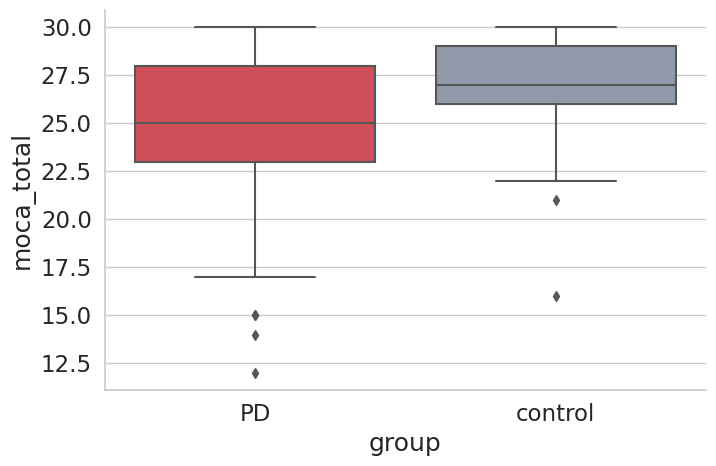

In [16]:
paper_df = paper_df.rename(columns={"TOTAL SCORE (make sure to include extra point for 12 years or less of education):    SCORE TOTAL (assurez-vous d'inclure un point supplémentaire pour 12 ans ou moins d'éducation) : " :"moca_total"})
plot_df = paper_df[paper_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"]

sns.set_theme(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="moca_total",x="group",
                    kind="box", palette=palette, 
                    data=plot_df, aspect=1.5, height=5, sharey=False)

In [17]:
cat_cols = ["group"]
score_cols = ["moca_total"]

# paper_df = paper_df[paper_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"]

for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_group_df = paper_df[paper_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: PD ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count   PD  \
0                   Baseline (Arm 1: C-OPN)    179  179   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)     34   34   
2            pre-redcap-baseline-1 (legacy)     22   22   
3  18 Months Follow-Up/Suivi (Arm 1: C-OPN)     12   12   
4            pre-redcap-baseline-2 (legacy)      1    1   

                                    moca_total  
0  non-null-count: 178 25.0 (3.6) [12.0, 30.0]  
1   non-null-count: 34 25.2 (3.1) [18.0, 30.0]  
2   non-null-count: 22 26.8 (2.9) [21.0, 30.0]  
3   non-null-count: 12 25.9 (2.5) [22.0, 29.0]  
4    non-null-count: 1 28.0 (nan) [28.0, 28.0]  
----------
*** group: control ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count  control  \
0                   Baseline (Arm 1: C-OPN)     59       59   
1  12 Months Follow-U

### Neuropsy scores

In [12]:
paper_df = pd.merge(demo_df.drop(columns=["redcap_event_name"]), neuropsy_df, on=["participant_id"], how="right")
n_tabular_participants = paper_df["participant_id"].nunique()
print(f"Number of participants: {n_tabular_participants}")

# Filter and replace values
paper_df = subset_and_replace_df(paper_df, participant_inclusion_criteria, col_val_replacement_criteria)
n_paper_participants = paper_df["participant_id"].nunique()
print(f"Number of participants after event and group filter: {n_paper_participants}")

redcap_events = paper_df["redcap_event_name"].unique()
print(f"redcap events: {redcap_events}")

print("-"*50)
print("Scores with lowest attrition (sorted)")
raw_score_cols = list(paper_df.columns[paper_df.columns.str.contains("score")]) + list(paper_df.columns[paper_df.columns.str.contains("aw")])
raw_scores_paper_df = paper_df[["participant_id", "redcap_event_name"] + raw_score_cols].copy()
raw_scores_paper_df[raw_scores_paper_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"].isna().sum().sort_values(ascending=True)[:20]

Number of participants: 306
Number of participants after event and group filter: 275
redcap events: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 'pre-redcap-baseline-1 (legacy)' 'pre-redcap-baseline-2 (legacy)']
--------------------------------------------------
Scores with lowest attrition (sorted)


participant_id                           0
redcap_event_name                        0
Copy raw                                17
Trial 2 raw                             17
Trial total 1,2,3 (Raw score)           17
Immediate recall raw                    17
Trial 3 raw                             17
Delayed recall raw                      17
Trial 1 raw                             17
Trial total 1,2,3 (Raw score)           17
Trail A raw score (time in sec.)        17
Trail A raw score (time in sec.)        17
Trial 4 delayed (Raw score)             18
BNT sans indice (Raw score)             18
Command Clock raw (max 10)              18
Trial 4 delayed (Raw score)             18
BNT sans indice (Raw score)             18
Letter Fluency S (Raw score)            19
Semantic Fluency Actions (Raw score)    19
Copy Clock raw (max 10)                 19
dtype: int64

In [13]:
raw_scores_paper_df[raw_scores_paper_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"].isna().sum().sort_values(ascending=False)[:20]

Letter Fluency Total (Raw score)                               225
Semantic Fluency Total (Raw score)                             225
Semantic Fluency Total (Raw score)                             225
Letter Fluency Total (Raw score)                               225
Stroop GOLDEN, ink, uncorrected errors (raw score)             196
Stroop GOLDEN : ink, self-corrected errors (raw score)         196
Stroop GOLDEN : ink, self-corrected errors (raw score)         196
Stroop GOLDEN, ink, uncorrected errors (raw score)             196
STROOP GOLDEN : colors, self-corrected errors (raw scores)     195
STROOP GOLDEN : colors, self-corrected errors (raw scores)     195
STROOP GOLDEN, words, uncorrected errors (raw score)           191
STROOP GOLDEN : words, self-corrected errors (raw score)       191
STROOP GOLDEN, words, uncorrected errors (raw score)           191
STROOP GOLDEN : words, self-corrected errors (raw score)       191
Stroop - D-Kefs - Cond.3 - INK: Time (sec) (Raw score)        

In [14]:
index_cols = ["participant_id", "redcap_event_name","group"]
cat_cols = []

neuropsy_source = "redcap"

# redcap data
if neuropsy_source == "redcap":
    score_cols = [                   
                    "Repetitions total 1,2,3 (Raw score)",
                    "Digit Span Forward - total correct (Raw score) ",
                    "Digit span forward - longest correct serie (Raw score)",
                    "Digit Span Backward - total correct (Raw score)",
                    "Digit span backward - longest correct serie (Raw score)  ",    
                    "Command Clock raw (max 10)",
                    "Copy Clock raw (max 10)",
                    "STROOP GOLDEN : words, self-corrected errors (raw score)",
                    "STROOP GOLDEN, words, uncorrected errors (raw score)",
                    "STROOP GOLDEN : colors, self-corrected errors (raw scores)",
                    "Stroop GOLDEN : ink, self-corrected errors (raw score)",
                    "Stroop GOLDEN, ink, uncorrected errors (raw score)",
                    "Letter Fluency Total (Raw score)",                    
                    "Trail A raw score (time in sec.)",
                    "Trial total 1,2,3 (Raw score)",                            
                    "Trial 4 delayed (Raw score)",                                   
                    "BNT sans indice (Raw score)",                                   
                    "Letter Fluency F (Raw score)",                                  
                    "Semantic Fluency Actions (Raw score)",
                    "Letter Fluency S (Raw score)",                         
                    "Semantic Fluency Animals (Raw score)",
                    "Letter Fluency A (Raw score)",                                   
                    "Trail B raw score (time in sec.)",
                    "Trail B Errors raw score",
                    "Brixton raw score",
                ]

# BD_RPQ data
if neuropsy_source == "local":
    score_cols = [
                    "HVLT Trial total 1,2,3 (Raw score)",
                    "Clock Command (Raw score)",
                    "Clock Copy (Raw score)",
                    "Semantic Fluency Total (Raw score)",
                    "RCFT Copy (Raw score)",
                    "Letter Fluency Total (Raw score)",
                    "STROOP GOLDEN : words, self-corrected errors (raw score)",
                    "STROOP GOLDEN : colors, self-corrected errors (raw scores)",
                    "Stroop GOLDEN : ink, self-corrected errors (raw score)",                
                    ]

neuropsy_vars = index_cols + cat_cols + score_cols
paper_df = paper_df[neuropsy_vars]
n_participants = paper_df["participant_id"].nunique()
print(f"Number of participants: {n_participants}")

neuropsy_df.head()

Number of participants: 275


,participant_id,redcap_event_name,Copy raw,Digit Span Forward - total correct (Raw score),Semantic Fluency Total (Raw score),Delayed recall time (sec),Stroop - D-Kefs - Cond.3: self-corrected errors (Raw score),Digit span forward - longest correct serie (Raw score),Trial 4 delayed (Raw score),Copy time (sec),...,Was the WAIS IV Digit Span test administered?,Command Clock raw (max 10),Stroop - D-Kefs - Cond. 3 - 1 (time),Letter Fluency Total (Automatic Calculation),Letter Fluency F (Raw score),Stroop - D-Kefs - cond. 1: self-corrected errors (Raw score),"Intrusions total 1,2,3 (Raw score)",BNT sans indice + IS,Letter Fluency A (Raw score),neuropsy_age
0,MNI0028,Baseline (Arm 1: C-OPN),35,8.0,33.0,155.0,0.0,6.0,9.0,125.0,...,"Yes, completed",9.0,37.0,40.0,18.0,0.0,1.0,36.0,6.0,60.19
1,MNI0056,Baseline (Arm 1: C-OPN),28,8.0,NaN,NaN,2.0,5.0,5.0,321.0,...,"Yes, completed",6.0,NaN,17.0,9.0,0.0,1.0,49.0,4.0,79.19
2,MNI0058,Baseline (Arm 1: C-OPN),26,11.0,NaN,NaN,6.0,7.0,11.0,190.0,...,"Yes, completed",10.0,NaN,24.0,9.0,2.0,0.0,57.0,5.0,57.43
3,MNI0068,Baseline (Arm 1: C-OPN),"21,5",9.0,NaN,NaN,0.0,6.0,9.0,144.0,...,"Yes, completed",8.0,NaN,23.0,9.0,2.0,1.0,50.0,5.0,69.28
4,MNI0079,Baseline (Arm 1: C-OPN),30,6.0,NaN,NaN,2.0,5.0,11.0,151.0,...,"Yes, completed",9.0,NaN,47.0,16.0,1.0,0.0,53.0,16.0,50.16


In [16]:
for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    # dx_group_df = paper_df[(paper_df["group"]==dx_group) & (paper_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)")].copy()
    dx_group_df = paper_df[(paper_df["group"]==dx_group) ].copy()
    table_df = get_group_table_stats(dx_group_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: PD ***
Counting 0 and averaging 25
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count  \
0                   Baseline (Arm 1: C-OPN)    208   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)    208   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)    208   
3            pre-redcap-baseline-1 (legacy)     30   
4            pre-redcap-baseline-2 (legacy)      1   

         Repetitions total 1,2,3 (Raw score)  \
0  non-null-count: 118 1.6 (2.2) [0.0, 16.0]   
1     non-null-count: 0 nan (nan) [nan, nan]   
2   non-null-count: 13 2.5 (3.3) [0.0, 12.0]   
3     non-null-count: 0 nan (nan) [nan, nan]   
4     non-null-count: 0 nan (nan) [nan, nan]   

  Digit Span Forward - total correct (Raw score)   \
0       non-null-count: 128 9.4 (2.2) [4.0, 16.0]   
1          non-null-count: 0 nan (nan) [nan, nan]   
2       non-null-count: 13 10.0 (1.7) [6.0, 12.0]   
3          non-null-count: 0 nan (nan) [nan, nan]   
4          non-null-count:

In [17]:
table_df

,redcap_event_name,count,"Repetitions total 1,2,3 (Raw score)",Digit Span Forward - total correct (Raw score),Digit span forward - longest correct serie (Raw score),Digit Span Backward - total correct (Raw score),Digit span backward - longest correct serie (Raw score),Command Clock raw (max 10),Copy Clock raw (max 10),"STROOP GOLDEN : words, self-corrected errors (raw score)",...,Trial 4 delayed (Raw score),BNT sans indice (Raw score),Letter Fluency F (Raw score),Semantic Fluency Actions (Raw score),Letter Fluency S (Raw score),Semantic Fluency Animals (Raw score),Letter Fluency A (Raw score),Trail B raw score (time in sec.),Trail B Errors raw score,Brixton raw score
0,Baseline (Arm 1: C-OPN),67,"non-null-count: 50 1.1 (1.4) [0.0, 5.0]","non-null-count: 50 10.3 (2.3) [6.0, 16.0]","non-null-count: 50 6.6 (1.3) [4.0, 9.0]","non-null-count: 50 9.6 (2.5) [5.0, 15.0]","non-null-count: 50 5.4 (1.4) [3.0, 8.0]","non-null-count: 63 9.3 (1.0) [5.0, 10.0]","non-null-count: 63 9.6 (0.6) [8.0, 10.0]","non-null-count: 13 0.1 (0.3) [0.0, 1.0]",...,"non-null-count: 63 9.7 (2.1) [4.0, 12.0]","non-null-count: 63 54.6 (4.1) [36.0, 60.0]","non-null-count: 62 14.7 (3.9) [7.0, 22.0]","non-null-count: 62 18.7 (4.9) [9.0, 28.0]","non-null-count: 62 14.4 (3.7) [7.0, 23.0]","non-null-count: 62 21.5 (5.0) [8.0, 31.0]","non-null-count: 62 12.5 (3.6) [5.0, 23.0]","non-null-count: 63 67.6 (25.8) [28.0, 134.0]","non-null-count: 63 0.3 (0.7) [0.0, 4.0]","non-null-count: 62 16.4 (5.7) [3.0, 34.0]"
1,12 Months Follow-Up/Suivi (Arm 1: C-OPN),67,"non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]",...,"non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]"
2,18 Months Follow-Up/Suivi (Arm 1: C-OPN),67,"non-null-count: 19 0.7 (1.1) [0.0, 3.0]","non-null-count: 19 10.1 (1.6) [8.0, 13.0]","non-null-count: 19 6.6 (1.0) [5.0, 8.0]","non-null-count: 19 9.1 (1.9) [6.0, 12.0]","non-null-count: 19 5.1 (1.3) [3.0, 7.0]","non-null-count: 19 9.7 (0.5) [9.0, 10.0]","non-null-count: 19 9.9 (0.3) [9.0, 10.0]","non-null-count: 0 nan (nan) [nan, nan]",...,"non-null-count: 19 10.2 (1.8) [5.0, 12.0]","non-null-count: 19 55.3 (4.2) [44.0, 60.0]","non-null-count: 19 18.1 (4.0) [13.0, 27.0]","non-null-count: 19 19.8 (4.3) [13.0, 32.0]","non-null-count: 19 17.3 (4.2) [10.0, 25.0]","non-null-count: 19 23.9 (3.8) [17.0, 34.0]","non-null-count: 19 14.7 (4.4) [9.0, 23.0]","non-null-count: 19 61.5 (21.7) [36.0, 124.0]","non-null-count: 19 0.3 (0.6) [0.0, 2.0]","non-null-count: 19 15.0 (4.7) [4.0, 22.0]"
3,pre-redcap-baseline-1 (legacy),9,"non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]",...,"non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]","non-null-count: 0 nan (nan) [nan, nan]"
